# Etap 2 - Eksploracyjna analiza danych i preprocessing

Kolejny etap projektu skupia się na:

* Zbadaniu struktury danych.
* Sprawdzeniu wartości brakujących oraz odstających (usunięcie brakujących danych / usunięcie odstających).
* Identyfikacji najbardziej istotnych cech zbioru (feature selection).

## Spis treści
1. [Import bibliotek i inicjalizacja klienta Dask](#import-bibliotek-i-inicjalizacja-klienta-dask)
2. [Próba wczytania danych](#próba-wczytania-danych)
3. [Badanie struktury danych](#badanie-struktury-danych)
4. [Wczytanie danych](#wczytanie-danych)
5. [Wstępny wybór cech](#wstępny-wybór-cech)
6. [Wartości odstające](#wartości-odstające)
7. [Wybór istotnych cech](#wybór-istotnych-cech)
8. [Zapis danych](#zapis-danych)

## Import bibliotek i inicjalizacja klienta Dask

In [57]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os

THIRD_POW_1024 = 1_073_741_824

In [2]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(
    processes=True,
    n_workers=2,
    threads_per_worker=4,
    memory_limit='12GB',  # Przy ustawieniu limitu pamięci RAM na 12 GB na pracownika
                          # Dask dosyć efektywnie korzysta z mechanizmu spill-to-disk, (który przenosi dane na dysk).
                          # Dodatkowy rozmiar SWAP (64 GB) może (nie musi) zapobiec zabijaniu procesów
                          # przez system operacyjny w przypadku przeciążenia pamięci RAM,
                          # (spill-to-disk działa niezależnie od konfiguracji SWAP).
)

client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 8,Total memory: 22.35 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54370,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 8
Started: Just now,Total memory: 22.35 GiB
Comm: tcp://127.0.0.1:54381,Total threads: 4
Dashboard: http://127.0.0.1:54383/status,Memory: 11.18 GiB
Nanny: tcp://127.0.0.1:54373,


## Próba wczytania danych

In [3]:
def load_taxi_data(start_year, end_year, end_month=12, folder='data', chunksize='128MB'):
    paths = []
    total_size = 0
    
    for year in range(start_year, end_year + 1):
        last_month = end_month if year == end_year else 12
        
        for month in range(1, last_month + 1):
            file_name = f'yellow_tripdata_{year}-{month:02d}.parquet'
            filepath = os.path.join(folder, file_name)
            
            if os.path.exists(filepath):
                paths.append(filepath)
                total_size += os.path.getsize(filepath)
                
            if not os.path.exists(filepath):
                print(f'Plik {file_name} nie istnieje.')
    
    if paths:
        total_size_gb = total_size / THIRD_POW_1024
        print(f'\nWczytywanie {len(paths)} plików...')
        print(f'Łączny rozmiar plików: {total_size_gb:.2f} GB przed dekompresją.\n\n')
        return dd.concat([dd.read_parquet(file, engine='pyarrow', chunksize=chunksize) for file in paths], ignore_index=True)
    if not paths:
        print('Nie znaleziono plików do wczytania')
        return None

In [4]:
ddf = load_taxi_data(start_year=2009, end_year=2024)
ddf.info()

Plik yellow_tripdata_2024-11.parquet nie istnieje.
Plik yellow_tripdata_2024-12.parquet nie istnieje.

Wczytywanie 190 plików...
Łączny rozmiar plików: 28.77 GB przed dekompresją.

<class 'dask_expr.DataFrame'>
Columns: 45 entries, vendor_name to Airport_fee
dtypes: datetime64[us](2), object(5), float64(30), string(8)

In [5]:
ddf.head()

,vendor_name,Trip_Pickup_DateTime,Trip_Dropoff_DateTime,Passenger_Count,Trip_Distance,Start_Lon,Start_Lat,Rate_Code,store_and_forward,End_Lon,...,tpep_pickup_datetime,tpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,extra,improvement_surcharge,congestion_surcharge,airport_fee,Airport_fee
0,VTS,2009-01-04 02:52:00,2009-01-04 03:02:00,1.0,2.63,-73.991957,40.721567,NaN,NaN,-73.993803,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,VTS,2009-01-04 03:31:00,2009-01-04 03:38:00,3.0,4.55,-73.982102,40.736290,NaN,NaN,-73.955850,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,VTS,2009-01-03 15:43:00,2009-01-03 15:57:00,5.0,10.35,-74.002587,40.739748,NaN,NaN,-73.869983,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,DDS,2009-01-01 20:52:58,2009-01-01 21:14:00,1.0,5.00,-73.974267,40.790955,NaN,NaN,-73.996558,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,DDS,2009-01-24 16:18:23,2009-01-24 16:24:56,1.0,0.40,-74.001580,40.719382,NaN,NaN,-74.008378,...,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Przy próbie:
`ddf.describe().compute()`
Na wszystkich danych Dask po 30 minutach przerwał pracę.

Przy próbie:
`ddf.describe().compute()`
Na danych od 2016 do 2024 Dask zajął 70GB przestrzeni dyskowej i po godzinie tempo przetwarzania spadło praktycznie do 0.

---

Zbadana zostanie najpierw struktura danych i dobrane zostaną optymalne typy przed pracą na większym zbiorze. 

In [6]:
ddf = load_taxi_data(start_year=2024, end_year=2024, end_month=1)
ddf.info()


Wczytywanie 1 plików...
Łączny rozmiar plików: 0.05 GB przed dekompresją.


<class 'dask_expr.DataFrame'>
Columns: 19 entries, VendorID to Airport_fee
dtypes: datetime64[us](2), float64(10), int32(3), int64(3), string(1)

## Badanie struktury danych

In [7]:
ddf.describe().compute()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
count,2.964624e+06,2964624,2964624,2.824462e+06,2.964624e+06,2.824462e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.964624e+06,2.824462e+06,2.824462e+06
mean,1.754204e+00,NaN,NaN,1.339281e+00,3.652169e+00,2.069359e+00,1.660179e+02,1.651167e+02,1.161271e+00,1.817506e+01,1.451598e+00,4.833823e-01,3.335870e+00,5.270212e-01,9.756319e-01,2.680150e+01,2.256122e+00,1.411611e-01
std,4.325902e-01,NaN,NaN,8.502817e-01,2.254626e+02,9.823219e+00,6.362391e+01,6.931535e+01,5.808686e-01,1.894955e+01,1.804102e+00,1.177600e-01,3.896551e+00,2.128310e+00,2.183645e-01,2.338558e+01,8.232747e-01,4.876239e-01
min,1.000000e+00,2002-12-31 22:59:39,2002-12-31 23:05:41,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,-8.990000e+02,-7.500000e+00,-5.000000e-01,-8.000000e+01,-8.000000e+01,-1.000000e+00,-9.000000e+02,-2.500000e+00,-1.750000e+00
25%,2.000000e+00,2024-01-09 15:59:19.750000,2024-01-09 16:16:23,1.000000e+00,1.000000e+00,1.000000e+00,1.320000e+02,1.140000e+02,1.000000e+00,8.600000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.000000e+00,1.538000e+01,2.500000e+00,0.000000e+00
50%,2.000000e+00,2024-01-17 10:45:37.500000,2024-01-17 11:03:51.500000,1.000000e+00,1.680000e+00,1.000000e+00,1.620000e+02,1.620000e+02,1.000000e+00,1.280000e+01,1.000000e+00,5.000000e-01,2.700000e+00,0.000000e+00,1.000000e+00,2.010000e+01,2.500000e+00,0.000000e+00
75%,2.000000e+00,2024-01-24 18:23:52.250000,2024-01-24 18:40:29,1.000000e+00,3.110000e+00,1.000000e+00,2.340000e+02,2.340000e+02,1.000000e+00,2.050000e+01,2.500000e+00,5.000000e-01,4.120000e+00,0.000000e+00,1.000000e+00,2.856000e+01,2.500000e+00,0.000000e+00
max,6.000000e+00,2024-02-01 00:01:15,2024-02-02 13:56:52,9.000000e+00,3.127223e+05,9.900000e+01,2.650000e+02,2.650000e+02,4.000000e+00,5.000000e+03,1.425000e+01,4.000000e+00,4.280000e+02,1.159200e+02,1.000000e+00,5.000000e+03,2.500000e+00,1.750000e+00


# Opis Kolumn

| Kolumna                  | Opis                                                                                                                                               |
|--------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------|
| **VendorID**             | Kod dostawcy usługi.                                                                                                                               |
| **tpep_pickup_datetime** | Data i godzina rozpoczęcia podróży.                                                                                                                |
| **tpep_dropoff_datetime**| Data i godzina zakończenia podróży.                                                                                                                |
| **passenger_count**      | Liczba pasażerów w trakcie podróży.                                                                                                                |
| **trip_distance**        | Odległość podróży w milach.                                                                                                                        |
| **RatecodeID**           | Kod taryfy: <br> 1 - Standardowa taryfa <br> 2 - JFO (na lotnisko JFK) <br> 3 - Newark <br> 4 - Podróż negocjowana <br> 5 - Darmowa <br> 6 - Grupa |
| **store_and_fwd_flag**   | Flaga przechowywania i przesyłania: <br> Y - Dane podróży zostały zapisane lokalnie, ponieważ brakowało połączenia <br> N - Dane zostały przesłane |
| **PULocationID**         | Kod strefy początkowej podróży (pickup).                                                                                                           |
| **DOLocationID**         | Kod strefy końcowej podróży (drop-off).                                                                                                            |
| **payment_type**         | Typ płatności: <br> 1 - Gotówka <br> 2 - Karta kredytowa <br> 3 - Brak opłaty <br> 4 - Dyskusyjna opłata <br> 5 - Zwrot środków                    |
| **fare_amount**          | Koszt przejazdu przed doliczeniem dodatkowych opłat.                                                                                               |
| **extra**                | Dodatkowe opłaty: np. za przejazd nocny lub za godzinę szczytu.                                                                                    |
| **mta_tax**              | Podatek MTA (Metropolitan Transportation Authority).                                                                                               |
| **tip_amount**           | Kwota napiwku.                                                                                                                                     |
| **tolls_amount**         | Koszt opłat drogowych.                                                                                                                             |
| **improvement_surcharge**| Opłata dodatkowa na rzecz poprawy infrastruktury.                                                                                                  |
| **total_amount**         | Całkowity koszt podróży (łącznie z opłatami dodatkowymi i napiwkiem).                                                                              |
| **congestion_surcharge** | Opłata dodatkowa za korki.                                                                                                                         |
| **airport_fee**          | Opłata za transport do/z lotniska.                                                                                                                 |


In [8]:
def data_summary(dask_dataframe):
    summary_data = []
    
    for column in dask_dataframe.columns:
        dtype = str(dask_dataframe[column].dtype)
        non_null_count = dask_dataframe[column].count().compute()
        unique_count = dask_dataframe[column].nunique().compute()
        total_count = len(dask_dataframe)
        missing_count = total_count - non_null_count
        missing_percentage = (missing_count / total_count) * 100
        
        summary_data.append({
            'Column': column,
            'Data Type': dtype,
            'Non-Null Count': non_null_count,
            'Unique Count': unique_count,
            'Missing Count': missing_count,
            'Missing Percentage': missing_percentage
        })
    
    return pd.DataFrame(summary_data)

In [9]:
data_summary(ddf)

,Column,Data Type,Non-Null Count,Unique Count,Missing Count,Missing Percentage
0,VendorID,int32,2964624,3,0,0.000000
1,tpep_pickup_datetime,datetime64[us],2964624,1575706,0,0.000000
2,tpep_dropoff_datetime,datetime64[us],2964624,1574780,0,0.000000
3,passenger_count,int64,2824462,10,140162,4.727817
4,trip_distance,float64,2964624,4489,0,0.000000
5,RatecodeID,int64,2824462,7,140162,4.727817
6,store_and_fwd_flag,string,2824462,2,140162,4.727817
7,PULocationID,int32,2964624,260,0,0.000000
8,DOLocationID,int32,2964624,261,0,0.000000
9,payment_type,int64,2964624,5,0,0.000000


In [10]:
ddf = ddf.dropna()

Na podstawie podsumowania można stwierdzić, że Dask nie wszędzie przydzielił kolumnie optymalny typ danych. Szczególnie zwracając uwagę na kolumnę `Unique Count`.

In [11]:
def memory_usage_gb(ddf):
    return ddf.map_partitions(lambda df: df.memory_usage(deep=True).sum()).compute().sum() / THIRD_POW_1024

In [12]:
print(f"Rzeczywisty rozmiar ddf: {memory_usage_gb(ddf):.2f} GB)")

Rzeczywisty rozmiar ddf: 0.39 GB)


In [13]:
dtypes = {
    'VendorID': 'category',
    # tpep_pickup_datetime OK
    # tpep_dropoff_datetime OK
    'passenger_count': 'float32',  # przy wczytywaniu z plików można ustawić float32 > dropna() > int8
    'trip_distance': 'float32',
    'RatecodeID': 'category',
    'store_and_fwd_flag': 'category',
    'PULocationID': 'category',
    'DOLocationID': 'category',
    'payment_type': 'category',
    'fare_amount': 'float32',
    'extra': 'float32',
    'mta_tax': 'float32',
    'tip_amount': 'float32',
    'tolls_amount': 'float32',
    'improvement_surcharge': 'category',
    'total_amount': 'float32',
    'congestion_surcharge': 'category',
    'Airport_fee': 'category'
}

In [14]:
ddf = ddf.astype(dtypes)

In [15]:
data_summary(ddf)

,Column,Data Type,Non-Null Count,Unique Count,Missing Count,Missing Percentage
0,VendorID,category,2824462,2,0,0.0
1,tpep_pickup_datetime,datetime64[us],2824462,1534626,0,0.0
2,tpep_dropoff_datetime,datetime64[us],2824462,1533080,0,0.0
3,passenger_count,float32,2824462,10,0,0.0
4,trip_distance,float32,2824462,4460,0,0.0
5,RatecodeID,category,2824462,7,0,0.0
6,store_and_fwd_flag,category,2824462,2,0,0.0
7,PULocationID,category,2824462,256,0,0.0
8,DOLocationID,category,2824462,261,0,0.0
9,payment_type,category,2824462,4,0,0.0


In [16]:
print(f"Rzeczywisty rozmiar ddf po zmianie typów: {memory_usage_gb(ddf):.2f} GB)")

Rzeczywisty rozmiar ddf po zmianie typów: 0.18 GB)


## Wczytanie danych

Dane od 2016 do 2024 to ~600 mln rekordów.
Dane od 2023 do 2024 to ~70 mln rekordów.

In [30]:
ddf = load_taxi_data(start_year=2023, end_year=2023)
ddf.info()


Wczytywanie 12 plików...
Łączny rozmiar plików: 0.59 GB przed dekompresją.
<class 'dask_expr.DataFrame'>
Columns: 20 entries, VendorID to Airport_fee
dtypes: datetime64[us](2), float64(13), int64(4), string(1)

In [31]:
ddf.columns

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee', 'Airport_fee'],
      dtype='object')

Jak widać, przy wczytywaniu większej liczby plików, liczba zmieniła się z 19 do 20 (airport_fee i Airport_fee)

In [32]:
ddf['Airport_fee'] = ddf['Airport_fee'].combine_first(ddf['airport_fee'])
ddf = ddf.drop(columns=['airport_fee'])

In [33]:
ddf = ddf.astype(dtypes)

In [34]:
data_summary(ddf)

,Column,Data Type,Non-Null Count,Unique Count,Missing Count,Missing Percentage
0,VendorID,category,38310226,3,0,0.000000
1,tpep_pickup_datetime,datetime64[us],38310226,19448115,0,0.000000
2,tpep_dropoff_datetime,datetime64[us],38310226,19438809,0,0.000000
3,passenger_count,float32,37000870,10,1309356,3.417772
4,trip_distance,float32,38310226,8493,0,0.000000
5,RatecodeID,category,37000870,7,1309356,3.417772
6,store_and_fwd_flag,category,37000870,2,1309356,3.417772
7,PULocationID,category,38310226,263,0,0.000000
8,DOLocationID,category,38310226,262,0,0.000000
9,payment_type,category,38310226,6,0,0.000000


In [35]:
ddf = ddf.dropna()

In [36]:
print(f"Rzeczywisty rozmiar ddf po zmianie typów i wstępnym czyszczeniu: {memory_usage_gb(ddf):.2f} GB)")

Rzeczywisty rozmiar ddf po zmianie typów i wstępnym czyszczeniu: 2.31 GB)


## Wstępny wybór cech
Model tworzony na etapie trzecim, będzie modelem regresji przewidującym wysokość napiwku. Logicznie analizująć można odrzucić cechy, które prawdopodobnie nie mają wpływu na napiwek:
* <b>VendorID</b> - identyfikator dostawcy usługi (np. Creative Mobile Technologies, VeriFone Inc.). Raczej nie ma związku z napiwkiem, ponieważ jest to tylko techniczny identyfikator.
* <b>store_and_fwd_flag</b> - wskazuje, czy dane zostały tymczasowo zapisane w pamięci lokalnej. Jest to jedynie techniczny wskaźnik.
* <b>improvement_surcharge</b> - opłata stała na rzecz infrastruktury i nie zależy od klienta, więc prawdopodobnie nie wpływa na napiwek.
* <b>mta_tax</b> - podatek na rzecz MTA, ustalony przez miasto. Również jest stały i nie zależy od klienta.
* <b>congestion_surcharge</b> - opłata za podróże w godzinach szczytu lub obszarach z dużym natężeniem ruchu. Jest ustalona z góry i nie powinna wpływać na decyzję klienta o napiwku (chociaż wyższa cena i korki mogą wpłynąć na chęć przyznania napiwku - jeśli tak jest, dane te są niejako zapisane w czasie podróży).
* <b>Airport_fee</b> - opłata za podróże na lotnisko. Jest stała i niezależna klienta (podobnie jak powyżej - dane również uwzględnione prawdopodobnie w danych lokalizacyjnych).
* <b>total_amount</b> - opłata zawiera już napiwek.

Zbiór danych na tym etapie zawiera blisko 40 mln rekordów.

In [37]:
columns_to_drop = ['VendorID', 'store_and_fwd_flag', 'improvement_surcharge', 'mta_tax', 'congestion_surcharge', 'Airport_fee', 'total_amount']

ddf = ddf.drop(columns=columns_to_drop)

## Wartości odstające

In [38]:
ddf.describe().compute()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount
count,37000870,37000870,3.700087e+07,3.700087e+07,3.700087e+07,3.700087e+07,3.700087e+07,3.700087e+07
min,2001-01-01 00:06:49,1970-01-20 10:16:32,0.000000e+00,0.000000e+00,-1.087300e+03,-1.000000e+01,-4.110000e+02,-9.130000e+01
25%,2023-04-05 20:17:42,2023-04-05 20:35:28,1.000000e+00,1.080000e+00,9.300000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,2023-07-01 00:42:13,2023-07-03 16:31:24,1.000000e+00,1.820000e+00,1.420000e+01,1.000000e+00,2.940000e+00,0.000000e+00
75%,2023-10-08 22:24:22,2023-10-08 22:41:33,2.000000e+00,3.590000e+00,2.330000e+01,2.500000e+00,4.620000e+00,0.000000e+00
max,2024-01-03 19:42:57,2024-01-03 20:15:55,9.000000e+00,1.617261e+05,3.869836e+05,1.000250e+04,4.174000e+03,6.655600e+02
mean,NaN,NaN,1.370426e+00,3.579956e+00,1.942136e+01,1.604824e+00,3.548746e+00,5.894585e-01
std,NaN,NaN,8.925924e-01,7.079758e+01,7.699984e+01,2.475239e+00,4.166229e+00,2.199247e+00


### Daty
Dane obejmują 2023 rok, ale jak widać najmniejsza data rozpoczęcia podróży wskazuje na 2001, a zakończenia na 1970. 

In [39]:
valid_date_range = (pd.Timestamp('2023-01-01'), pd.Timestamp('2024-12-31'))

ddf = ddf[
    (ddf['tpep_pickup_datetime'] >= valid_date_range[0]) &
    (ddf['tpep_pickup_datetime'] <= valid_date_range[1]) &
    (ddf['tpep_dropoff_datetime'] >= valid_date_range[0]) &
    (ddf['tpep_dropoff_datetime'] <= valid_date_range[1])
]

### Wartości ujemne
Niektóre rekordy dotyczą zwrotu płatności.

In [40]:
columns_to_check_negative = ['fare_amount', 'tip_amount', 'extra', 'tolls_amount']

for col in columns_to_check_negative:
    ddf = ddf[ddf[col] >= 0]

### Identyfikacja, wizualizacja i usunięcie pozostałych wartości odstających

trip_distance: LB: -2.6599997878074646   UP: 7.339999735355377


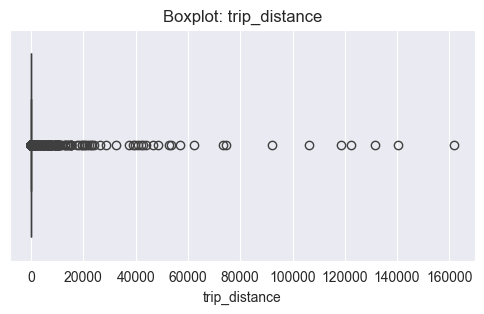

fare_amount: LB: -4.349998950958252   UP: 32.04999876022339


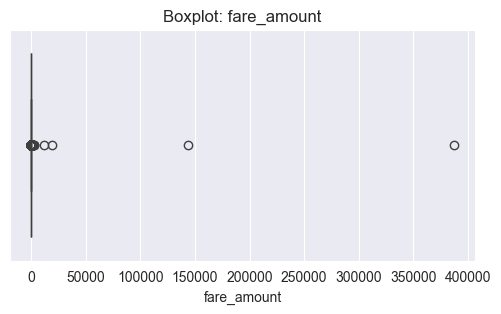

tip_amount: LB: -3.5   UP: 8.5


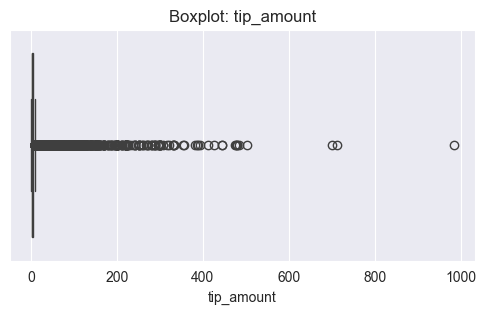

In [41]:
columns_to_check_outliers = ['trip_distance', 'fare_amount', 'tip_amount']  # pozostałe kolumny zawierają dane kategoryczne / stałe opłaty

for col in columns_to_check_outliers:
    q1 = ddf[col].quantile(0.25).compute()
    q3 = ddf[col].quantile(0.75).compute()
    iqr = q3 - q1

    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr

    print(f'{col}: LB: {lower_bound}   UP: {upper_bound}')

    pandas_df = ddf[[col]].compute()
    plt.figure(figsize=(6, 3))
    sns.boxplot(data=pandas_df, x=col)
    plt.title(f'Boxplot: {col}')
    plt.xlabel(col)
    plt.show()

    ddf = ddf[(ddf[col] >= lower_bound) & (ddf[col] <= upper_bound)]

In [42]:
ddf.describe().compute()

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,fare_amount,extra,tip_amount,tolls_amount
count,30889071,30889071,3.088907e+07,3.088907e+07,3.088907e+07,3.088907e+07,3.088907e+07,3.088907e+07
min,2023-01-01 00:00:05,2023-01-01 00:03:28,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2023-03-31 16:12:39,2023-03-31 16:21:48,1.000000e+00,1.000000e+00,8.600000e+00,0.000000e+00,1.000000e+00,0.000000e+00
50%,2023-07-01 00:42:13,2023-07-03 16:31:24,1.000000e+00,1.570000e+00,1.210000e+01,1.000000e+00,2.740000e+00,0.000000e+00
75%,2023-10-08 22:02:55,2023-10-08 22:16:39,1.000000e+00,2.500000e+00,1.770000e+01,2.500000e+00,3.980000e+00,0.000000e+00
max,2024-01-01 00:01:58,2024-01-01 23:02:22,9.000000e+00,7.330000e+00,3.205000e+01,9.638000e+01,8.500000e+00,1.969900e+02
mean,NaN,NaN,1.358168e+00,1.876989e+00,1.337724e+01,1.427676e+00,2.601593e+00,2.255877e-02
std,NaN,NaN,8.898440e-01,1.277832e+00,6.203824e+00,1.482804e+00,1.908791e+00,4.399458e-01


## Wybór istotnych cech
W przypadku regresji, analiza korelacji pozwala ocenić, które cechy są silnie powiązane z docelową zmienną `tip_amount`.
W tym celu utworzona zostanie nowa kolumna `trip_time` - różnica między `tpep_dropoff_datetime` a `tpep_pickup_datetime`.
\* można również dodać inne zmienne: godzina rozpoczęcia podróży, dzień tygodnia itp.

In [44]:
ddf['trip_time_seconds'] = (ddf['tpep_dropoff_datetime'] - ddf['tpep_pickup_datetime']).dt.total_seconds()

In [45]:
ddf = ddf.drop(columns=['tpep_dropoff_datetime', 'tpep_pickup_datetime'])

In [47]:
print(f'Min trip_time: {ddf['trip_time_seconds'].min().compute()} s, max trip_time: {ddf['trip_time_seconds'].max().compute()} s')

Min trip_time: -37025.0 s, max trip_time: 601751.0 s


Jak widać, na chwilę trzeba znów powrócić do usuwania wartości odstających.

In [48]:
ddf = ddf[ddf['trip_time_seconds'] >= 0]

trip_time_seconds: LB: -464.0   UP: 1952.0


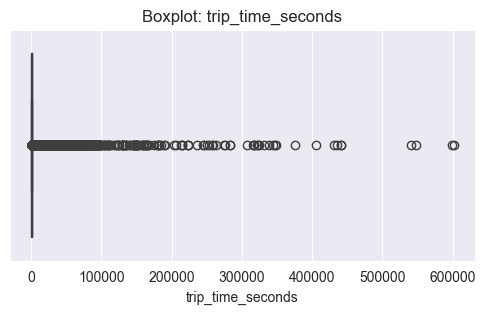

In [49]:
q1 = ddf['trip_time_seconds'].quantile(0.25).compute()
q3 = ddf['trip_time_seconds'].quantile(0.75).compute()
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f'trip_time_seconds: LB: {lower_bound}   UP: {upper_bound}')

pandas_df = ddf[['trip_time_seconds']].compute()
plt.figure(figsize=(6, 3))
sns.boxplot(data=pandas_df, x='trip_time_seconds')
plt.title(f'Boxplot: trip_time_seconds')
plt.xlabel('trip_time_seconds')
plt.show()

ddf = ddf[(ddf['trip_time_seconds'] >= lower_bound) & (ddf['trip_time_seconds'] <= upper_bound)]

In [50]:
print(f'Min trip_time: {ddf['trip_time_seconds'].min().compute()} s, max trip_time: {ddf['trip_time_seconds'].max().compute()} s')

Min trip_time: 0.0 s, max trip_time: 1952.0 s


Zmiana typów wymagana przez funkcję.

In [51]:
dtypes = {
    'trip_time_seconds': 'int16',
    'passenger_count': 'int8',
    'trip_distance': 'float32',
    'RatecodeID': 'int8',
    'PULocationID': 'int32',
    'DOLocationID': 'int32',
    'payment_type': 'int8',
    'fare_amount': 'float32',
    'extra': 'float32',
    'tip_amount': 'float32',
}

ddf = ddf.astype(dtypes)

In [52]:
correlation_matrix = ddf.corr().compute()

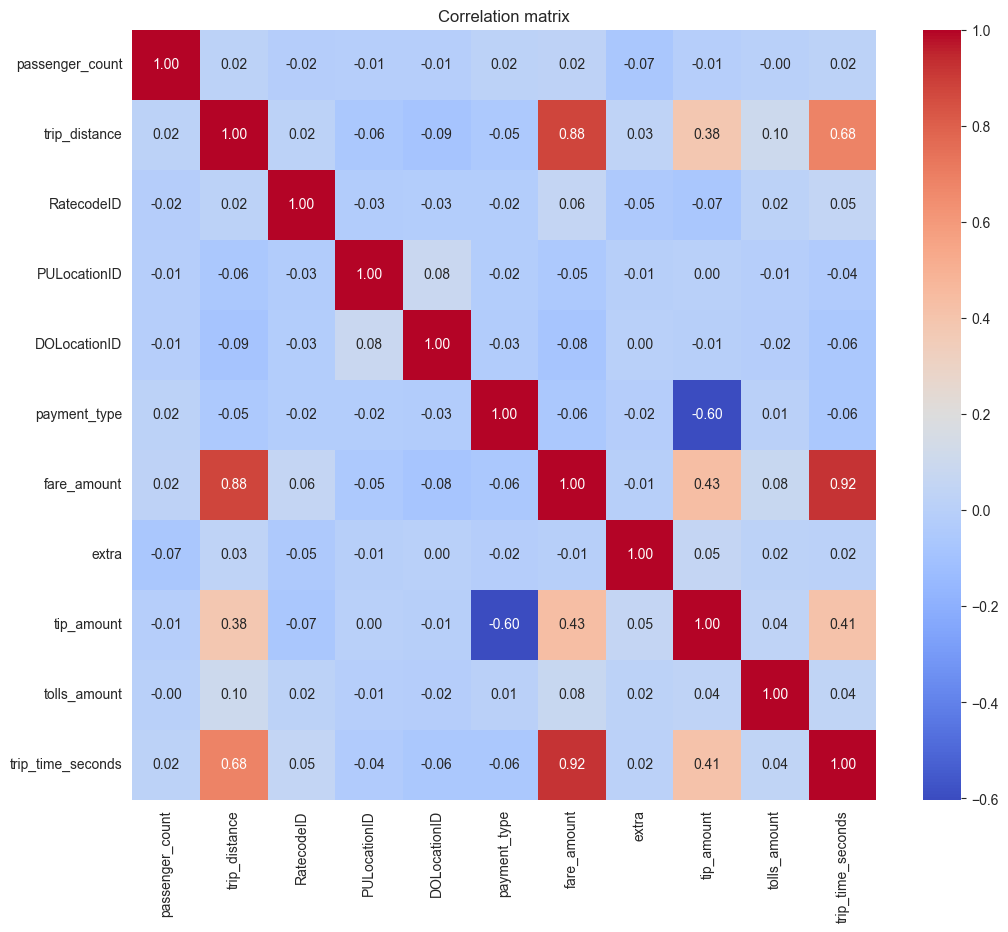

In [53]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

### Interpretacja macierzy korelacji
* `fare_amount` i `trip_distance` / `trip_time_seconds` (0.88 i 0.92): zarówno dystans jak i czas podróży wpływa na koszt przejazdu.
* `tip_amount` i `fare_amount` (0.43): umiarkowana korelacja wskazuje, że wysokość napiwku zależy od kosztu przejazdu.
* `tip_amount` i `payment_type` (-0.60): negatywna korelacja sugeruje, że sposób płatności (np. gotówka vs. karta) istotnie wpływa na napiwek.

### Usunięcie mniej istotnych cech
Na podstawie macierzy korelacji można rozważyć usunięcie cech, które mają niską korelację z tip_amount (bliskie 0).
* `passenger_count`: korelacja z tip_amount wynosi -0.01 – bardzo niska zależność.
* `RatecodeID`: korelacja wynosi -0.07 – niski wpływ na napiwek.
* `PULocationID` i `DOLocationID`: korelacje bliskie 0 – wpływ na napiwek jest marginalny.

In [56]:
ddf = ddf.drop(columns=['passenger_count', 'RatecodeID', 'PULocationID', 'DOLocationID'])

## Zapis danych

In [58]:
print(f"Finalnie liczba rekordów wynosi: {ddf.shape[0].compute()}, liczba cech {len(ddf.columns)}")

Finalnie liczba rekordów wynosi: 30527391, liczba cech 7


In [59]:
output_folder = 'processed_data'
os.makedirs(output_folder, exist_ok=True)

ddf = ddf.repartition(npartitions=10)

ddf.to_parquet(
    output_folder,
    engine='pyarrow',
    compression='snappy',
    write_metadata_file=False,
    name_function=lambda i: f"yellow_trip_data_processed_2024_{i+1:02d}"
)